##### Created by Jake Fredrich
##### Last Updated 4/10/2020
### About:
The overall objective of this project is to project revenue for several Countries, 1 Quarter into the future.  Exponential Smoothing,ARIMA modeling, and Linear Regression will be utilized do so dynamically. 

This notebook will be used to explore the different models listed above on one specific country.  Upon completion, a dynamic version of the final model will be created in a .py file, also located in this github folder.

The data source is a currency file found on the Kaggle notebook below, with modifications made to format the data in a way that was useful for me to use in my career as a Data Scientist at IBM.  These values in No Way represent true financial data at IBM.

Referenced - Topic 9 Part 1. Time series analysis in Python. found on Kaggle
https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python/data

In [8]:
# Import relevant Packages

import warnings # do not disturb
warnings.filterwarnings('ignore')

# used for accuracy metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulation
import matplotlib.pyplot as plt  # plots
import seaborn as sns  # additional plots
from math import sqrt
from math import isnan
from dateutil.relativedelta import relativedelta  # working with dates and style
from scipy.optimize import minimize  # for function minimization
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product  # useful functions
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Store Data
#### Lets look at Revenue from Germany

In [9]:
rev_df = pd.read_csv('currency.csv')
# select Germany and drop additional columns
rev_df = rev_df[rev_df['Country'] == "Germany"].drop(columns='Country') # select Germany and drop country column
rev_df.tail()

,Date,Revenue
22,11/1/2019,48553277
23,12/1/2019,43012450
24,1/1/2020,25842832
25,2/1/2020,33157740
26,3/1/2020,24611138


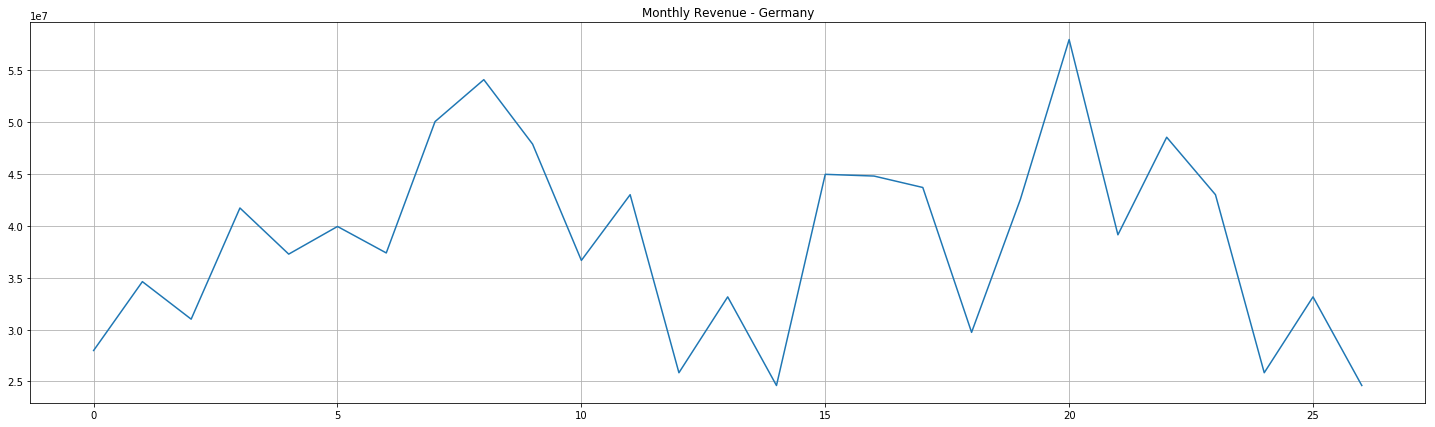

In [10]:
plt.figure(figsize=(25, 7))
plt.plot(rev_df.Revenue)
plt.title('Monthly Revenue - Germany')
plt.grid(True)
plt.show()

## Forecasting Quality Metrics
### These are common metrics used to measure quality of the forecasts we create.
### Most of the measurements can be created using the sklearn package

##### R squared: 
coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), (−∞,1]

In [11]:
sklearn.metrics.r2_score

NameError: name 'sklearn' is not defined

##### Mean Absolute Error:
this is an easy to interperet metric, it uses the same unit of measurement as the initial series,  [0,+∞)

In [12]:
sklearn.metrics.mean_absolute_error

NameError: name 'sklearn' is not defined

##### Mean Squared Error:
very commonly used metric, gives a higher penalty to large errrors and vice versa

In [13]:
sklearn.metrics.median_absolute_error

NameError: name 'sklearn' is not defined

##### Mean Squared Logarithmic Error:
similar to MSE but more weight is given to small mistakes as well.
Typically used when exponential trends exist. [0,+∞)

In [14]:
sklearn.metrics.mean_squared_log_error

NameError: name 'sklearn' is not defined

##### Mean Absolute  Percentage Error:
This is MAE calculated as a percentage.  
This is easy for management to interperate, and ultimately used in the final .py file
to determine which model to use.

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Moving Average
Starting with the hypothesis that tomorrow will be the same as today(very unlikely), we begin to analyze by determining what it's moving average is.  Moving average is the average of the previous n observations.  We use this to predict 1 observation into the future, and iterate.

As we continue to look into the future, our prediction quickly becomes unreliable as the averages become dependent upon the initial averages.  We can use the moving average in smoothing the original time series data, which helps to identify trends.

In [32]:
def moving_average(series, n):
    """
    :define:  Moving Average - assumption that the future value of our variable depends on the average of its k previous values
    :param series: dataframe with timestamps
    :param n: number of previous values to average
    :return: average of last n observations, predicts one observation in the future
    """
    return np.average(series[-n:])

moving_average(rev_df.Revenue, 6)

35720431.666666664

In Pandas, we have the DataFrame.rolling(window).mean() where the window represents the number of observations to include.  the wider the window, the smoother the trend.  Consider taking the average of every observation in a dataset.  We would have a straight line, as the average plotted would not change.  Identifying trends with the smoothing technique can help detect common patterns, especially in noisy data.

Lets look at a plot of the Moving Average.

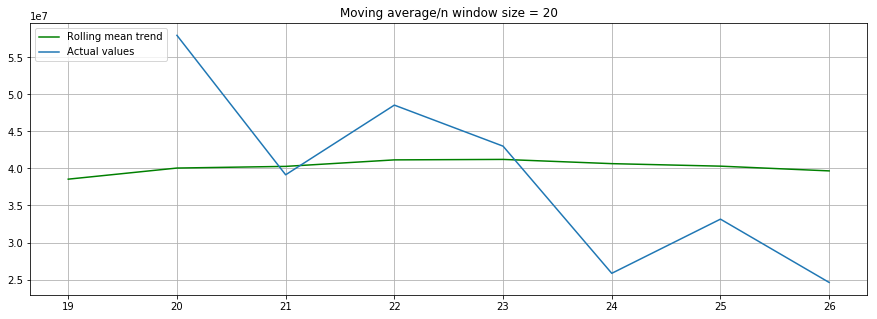

In [33]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
    :define: smoothe the original time series to identify trends.  Helps detect common patterns for noisy data
    :param series: dataframe with timeseries
    :param window: rolling window size - The number of observations used for calculating the statistic
    :param plot_intervals: show confidence intervals
    :param scale:
    :param plot_anomalies: show anomalies
    :return: Plot the time series with the Moving Average trend, predicts one observation in the future
    """

    rolling_mean = series.rolling(
        window=window).mean()  # smoothes the original series to identify trends. Same as moving_average function defined

    plt.figure(figsize=(15, 5))
    plt.title("Moving average/n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

    # Having the intervals, find abnormal values
    if plot_anomalies:
        anomalies = pd.DataFrame(index=series.index, columns=series.values)
        anomalies[series < lower_bond] = series[series < lower_bond]
        anomalies[series > upper_bond] = series[series > upper_bond]
        plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
    

plotMovingAverage(rev_df.Revenue, 20) # Notice the flat line when we approach the number of observations



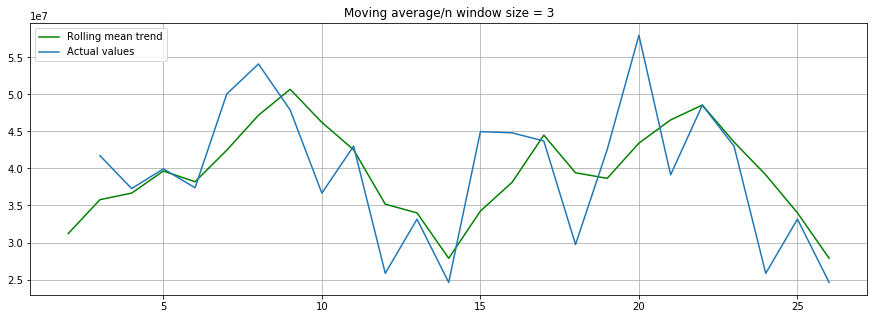

In [34]:
plotMovingAverage(rev_df.Revenue, 3) # Smooth by the previous 3 months(Quarter)

Analyzing the rolling mean trend with a quarterly window.  Note that we show no anomalies within our data, but there does seem to be a quarterly seasonal trend.  If the seasonal trend is stronger for other countries, we risk marking peaks in those trends as anomalies.

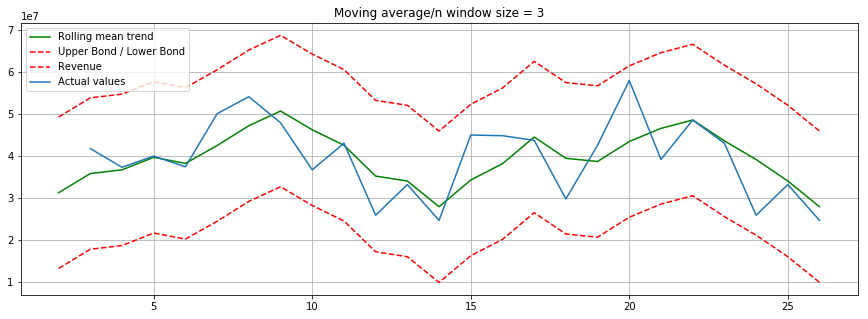

In [31]:
plotMovingAverage(rev_df.Revenue, 3, plot_intervals=True, plot_anomalies=True)


### Weighted Average
Weighted average is a modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.  It adds importance of the observations that are closer within the window n, n being the number of weights listed in the function below.


In [37]:
def weighted_average(series, weights):
    """
    :define: Weighted average is a modification to the moving average.  The weights sum up to 1, so that larger weights are assigned to more last recent observations
    :param series: dataframe with time series
    :param weights: list of weighted buckets that add up to 1. ex: [0.6, 0.3, 0.1]
    :return: return the weighted_average of a time series, predicts one observation in the future
    """
    result = 0.0
    weights.reverse()

    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

weighted_average(rev_df.Revenue, [0.9, 0.6, 0.3, 0.1])

[0.1, 0.3, 0.6, 0.9]


66625340.0

### Exponential Smoothing
Exponential smoothing is the process of weighting all available observations while exponentially decreasing the weights as we move further back in time.
The model value is a weighted average between the current true value and the previous model values.  

*
  
alpha = Weight, or smoothing factor, and defines how quickly we will "forget" the last available true observation.

*

The smaller α is, the more influence the previous observations have and the smoother the series is.  Exponentiality is hidden in the recursiveness of the function -- we multiply by (1−α) each time, which already contains a multiplication by (1−α) of previous model values.

In [47]:
def exponential_smoothing(series, alpha):
    """
    :define: Exponential smoothing weights all of the observations, while exponentially 
        decreasing the weights as we move further back in time. Exponentiality is 
        hidden in the resuriveness of the function: 
        
        y-hat = a * y-not + (1-a) * (previous y-not)
        
    :param series: pandas series with time stamps
    :param alpha: float [0.0, 1.0], smoothing parameter. 
        The smaller alpha is, the more influence the previous observations have, 
        and the smoother the series is
    :return: exponentially smoothed dataframe, predicts one observation in the future
    """
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    
    return result

# exponential_smoothing(rev_df.Revenue,.3)


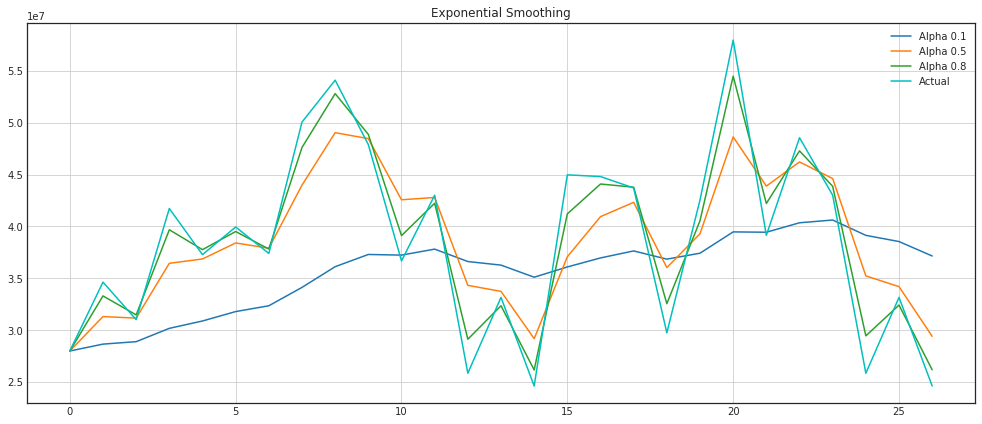

In [48]:

def plotExponentialSmoothing(series, alphas):
    """
    :param series: dataset with timestamps
    :param alphas: list of floats, smoothing parameters. The smaller alpha is, the more influence
        the previous observations have, and the smoother the series is
    :return: plot of exponentially smoothed dataframe, predicts one observation in the future
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(17, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

plotExponentialSmoothing(rev_df.Revenue, [0.1, 0.5, 0.8])

### Double Exponential Smoothing
The moving_average, weighted_average, and Exponential Smoothing functions defined above only produce a prediction for one single future point. The prior functions have learned to predict intercept, or expected series value.  We can add Series decomposition to improve our scope, by adding the slope component, or trend, b. 

By applyting the same exponential smoothing to the trend, we can use the previous weighted changes of the slope to produce a slope forecast. As a result, we get the following set of functions:

*

ℓx=αyx+(1−α)(ℓx−1+bx−1)

bx=β(ℓx−ℓx−1)+(1−β)bx−1

ŷ x+1=ℓx+bx

*

The first formula describes the intercept, which depends on the current value of the series. The second term is now split into previous values of the level and of the slope(trend). The second function describes the slope(trend), which depends on the level changes at the current step and on the previous value of the trend. In this case, the β, or Beta,
coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [49]:

def double_exponential_smoothing(series, alpha, beta):
    """
    :define: In the exponential_smoothing method we predict the intercept(level).  Now we will apply the same smoothing to the trend by assuming that the future direction of the
            series changes depends on the previous weighted changes
    :define2: The larger alpha and beta, the more weight the most recent observations will have and the less smoothed the model series will be
    :param series: dataset with timestamps
    :param alpha: float [0.0, 1.0], smoothing parameter for level. Responsible for the series smoothing around the trend
    :param beta: float [0.0, 1.0], smoothing parameter for trend. A weight for the exponential smoothing. Responsible for smoothing the trend itself
    :return: sum of the model values of the intercept and trend, a prediction 2 observations in the future
    """
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result
